<a href="https://colab.research.google.com/github/Regina00at/2020-01-20191068-JinaKim-Machine-Learning-Programming/blob/master/lesson5_sgd_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [3]:
path = Config().data_path()/'mnist'
path.mkdir(parents=True, exist_ok=True)
path.ls()
#make a new mnist file on /root/.fastai/data/. 
#list the things in the file

[]

In [0]:
! mv '/content/gdrive/My Drive/fastai-v3/mnist.pkl.gz' '/root/.fastai/data/mnist'
#bring the downloaded file from my google drive.

In [0]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
#open/unzip the mnist.pkl.gz file.
#'_' in python : doesn't care. In this case, we don't care about test case.

(50000, 784)

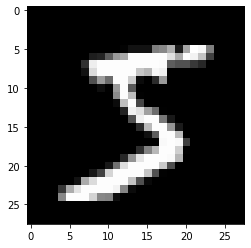

In [6]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape
#plt.imshow : show the first data
#shape of the data : 50000, 784
#784 : 28 by 28 pixels

In [7]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
#make the data as a tensor using map method.
n,c = x_train.shape
#number and columns. n would be 50000, c would be 784(28 by 28)
x_train.shape, y_train.min(), y_train.max()
#print the x_train shape again, minimum number we figure out is 0, and the maximum is 9 in mnist data.

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [0]:
bs=64
#batchsize 64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
#create dataset using TensorDataset(from pytorch). 
#Dataset looks like a list of x-y couples.
data = DataBunch.create(train_ds, valid_ds, bs=bs)
#DataBunch.create supports some convenient functions such as
#1. creating dataloader(in the below cell)
#2. shuffling the train data
#and so on.

In [9]:
x,y = next(iter(data.train_dl))
#bring next iterater(next and iter are the normal python)
#DataBunch.create method created the data.drain_dl(Data loader)
x.shape,y.shape
#x.shape : 64 for mini batch and 784 for 28 by 28 pixels
#y.shape : 64 for mini batch

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
#create a new class instead of using lesson 2's method.
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)
        #nn.Linear : work as x@a + b : we don't have to add something else.

    def forward(self, xb): return self.lin(xb)
        #call nn.Linear 

In [0]:
model = Mnist_Logistic().cuda()
#put cuda for weight matrices onto the GPU manually

In [12]:
model
#print it

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [13]:
model.lin
#check the model again

Linear(in_features=784, out_features=10, bias=True)

In [14]:
model(x).shape
#check the shape of it.

torch.Size([64, 10])

In [15]:
[p.shape for p in model.parameters()]
#check the shape of each parameters in the model

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr=2e-2
#set learning rate as 2e-2

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
def update(x,y,lr):
#copied from lesson 2 sgd;
    wd = 1e-5
    y_hat = model(x)
    # call y_hat as a model instead of x@a ; different function.
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
          #pytorch automatically creates what we need.(dataset)
            p.sub_(lr * p.grad)
            #loop through the parameters
            p.grad.zero_()
    return loss.item()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]
#list of losses for every x, y data in data.train_dataloader

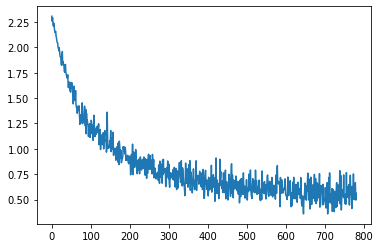

In [20]:
plt.plot(losses);
#plot the losses list
#the losses are decreasing.

In [0]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)
        #separate Linear method into two layors

    def forward(self, xb):
        x = self.lin1(xb)
        #call the first layor
        x = F.relu(x)
        return self.lin2(x)
        #call the second layor

In [0]:
model = Mnist_NN().cuda()
#put cuda for weight matrices onto the GPU manually

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]
#list of losses

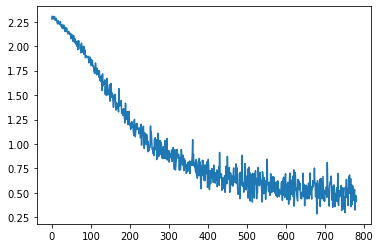

In [24]:
plt.plot(losses);
#plot the losses list, check the losses decreasing.

In [0]:
model = Mnist_NN().cuda()
#put cuda for weight matrices onto the GPU manually

In [0]:
def update(x,y,lr):
  #try another version of pytorch. 
    opt = optim.Adam(model.parameters(), lr)
    #this is the most important line for the new update.
    #take model.parameters() and optimize them using SGD
    #Adam is the bigger concept of SGD.
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    #easier and shorter code!
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]
#list of losses for each data

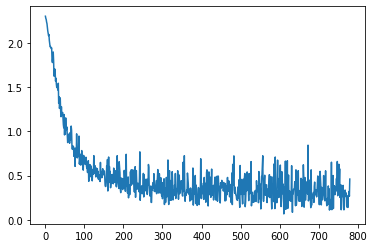

In [28]:
plt.plot(losses);
#plot it and check.

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)
#Learner do above things 
#tell Learner data, pytorch nn.module, loss function, something to print out.

In [30]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


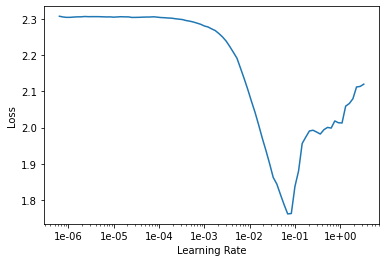

In [31]:
learn.lr_find()
learn.recorder.plot()
#find the learning rate and plot it.

In [35]:
learn.fit_one_cycle(1, 1e-2)
#fit the model with the learning rate we found.

epoch,train_loss,valid_loss,accuracy,time
0,0.223350,0.204254,0.944200,00:05


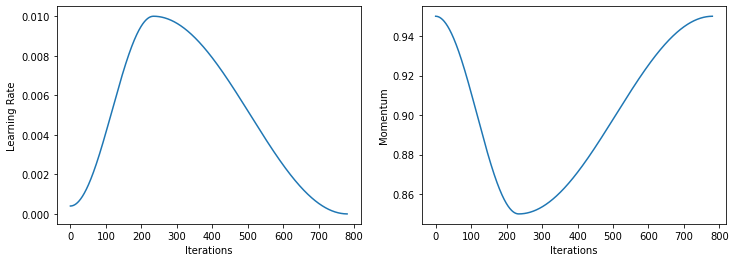

In [36]:
learn.recorder.plot_lr(show_moms=True)
#plotting the learning rate per batch.

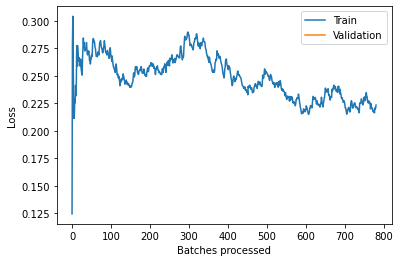

In [37]:
learn.recorder.plot_losses()
#losses per batch.

## fin